In [1]:
import cv2
import os

from astropy.io import fits

import matplotlib.pyplot as plt
import numpy as np

In [2]:
folder = "Ago08/"

files = [folder + file for file in sorted(os.listdir(folder))]

In [3]:
hdu = fits.open(files[0])[0]
data = hdu.data


In [4]:
# make vmin vmax 
vmin, vmax = np.percentile(data, [0.1, 99])

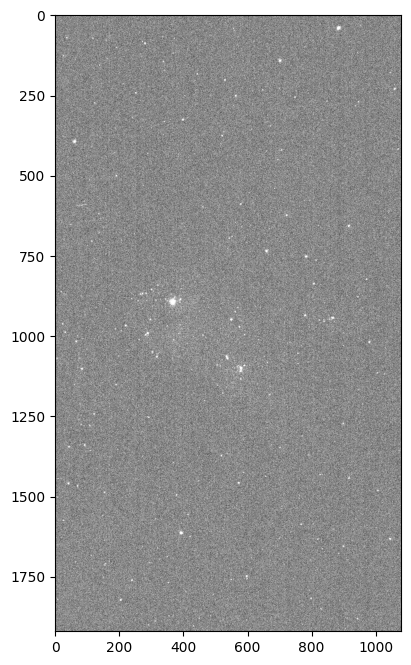

In [5]:
plt.figure(figsize=(8, 8))
plt.imshow(data, vmin=vmin, vmax=vmax, cmap="gray")

plt.show()

In [6]:
from astropy.io import fits
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
from astropy.stats import sigma_clipped_stats

from photutils.detection import DAOStarFinder
from photutils.centroids import centroid_com, centroid_2dg
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

DAO_FWHM = 3.0
DAO_SIGMA = 3.5
MIN_FLUX = 50
REFINE_METHOD = "com"   # "gaussian" or "com" or "none"
CUTOUT_SIZE = 20

def get_stars_positions(img: np.ndarray):
    mean, med, std = sigma_clipped_stats(img, sigma=3.0)
    daofind = DAOStarFinder(fwhm=DAO_FWHM, threshold=DAO_SIGMA * std)
    sources = daofind(img.astype(np.float32) - med)
    if sources is None or len(sources) == 0:
        return None

    if "flux" in sources.colnames:
        sources = sources[sources["flux"] > MIN_FLUX]
    if sources is None or len(sources) == 0:
        return None

    if REFINE_METHOD.lower() in ("gaussian", "com"):
        refined_x = []
        refined_y = []
        half = CUTOUT_SIZE // 2
        H, W = img.shape

        for star in sources:
            x, y = float(star["xcentroid"]), float(star["ycentroid"])
            x0 = max(0, int(round(x)) - half)
            x1 = min(W, int(round(x)) + half + 1)
            y0 = max(0, int(round(y)) - half)
            y1 = min(H, int(round(y)) + half + 1)

            cut = img[y0:y1, x0:x1].astype(np.float32)
            if cut.size < 9:
                refined_x.append(x)
                refined_y.append(y)
                continue

            _, med2, _ = sigma_clipped_stats(cut, sigma=3.0)
            cut2 = cut - med2
            cut2[cut2 < 0] = 0

            if REFINE_METHOD.lower() == "com":
                cx, cy = centroid_com(cut2)
            else:
                cx, cy = centroid_2dg(cut2)

            refined_x.append(x0 + float(cx))
            refined_y.append(y0 + float(cy))

        sources["xcentroid"] = refined_x
        sources["ycentroid"] = refined_y

    return sources

/Users/gustavoschwarz/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
stars = get_stars_positions(data)

In [8]:
stars

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,997.2372881355932,5.0423728813559325,0.2859536843927826,0.9122982619310793,-0.10505273023276963,25,32.0,256.0,-6.020599913279624,-0.07212227567740337
3,292.4257907542579,10.454987834549879,0.30988227842614813,-0.27381595970158484,-0.6411267100489608,25,32.0,144.0,-5.395906230238125,-0.046928625340525824
4,516.016129032258,26.870967741935484,0.895030301791552,-0.5534139667721893,0.15706791325262023,25,80.0,240.0,-5.950528104279015,-0.12761493413063613
5,666.2873969375736,26.669022379269727,0.3611416743383778,0.681197093788657,0.6917423159190534,25,32.0,112.0,-5.123045056675454,-0.04809343260399327
7,933.8214689265536,31.685875706214688,0.5168525668583746,0.37083862912814836,0.6128936358249057,25,48.0,128.0,-5.268024924119671,-0.046125656924135776
8,274.302752293578,35.00458715596331,0.5991995121439565,0.16772710288653747,0.07202054646764398,25,48.0,128.0,-5.268024924119671,-0.021507878643333415
9,455.70243902439023,36.678048780487806,0.23578424091994324,-0.5479334096692594,-0.5275227956238628,25,32.0,192.0,-5.708253071758874,-0.2157522333062305
10,270.7867298578199,37.56398104265403,0.9369530215948569,0.04183780209217276,0.5851607813367516,25,80.0,208.0,-5.795158337406904,-0.07791474104096652
11,882.3338122605364,39.83500957854406,0.33510720839221814,-0.08965607649000341,-0.06886521882043387,25,4608.0,50272.0,-11.753315408399699,-4.783377381633015


In [9]:
from astropy.table import Table

stars = Table(stars)

stars.sort('flux', reverse=True)

In [10]:
stars

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
339,365.87378446115287,894.1301253132832,0.6299107418466018,-0.2097283115339553,-0.2421868765610717,25,65024.0,411152.0,-14.035006017935421,-7.386762523303475
11,882.3338122605364,39.83500957854406,0.33510720839221814,-0.08965607649000341,-0.06886521882043387,25,4608.0,50272.0,-11.753315408399699,-4.783377381633015
693,392.32917964693667,1613.4835583246797,0.4911224855108305,0.42603241305864875,0.12651444688882682,25,6768.0,41392.0,-11.54229102843117,-5.198780244024743
162,60.40679173592971,393.56518641652815,0.7023830963542848,-0.4756069721580169,0.038952725601332935,25,6080.0,30016.0,-11.193382041747427,-4.808663818416682
464,578.070343275183,1100.3235790658414,0.3137842722184793,0.29021017296921725,-0.12299798949693476,25,2288.0,19216.0,-10.709157475147077,-4.204566186623363
286,781.0811957569913,752.069431051109,0.588373704506645,-0.0954006479122844,-0.01372211837049677,25,3312.0,15776.0,-10.49499224399284,-4.3716962475596315
373,548.0623328533223,948.2861551121168,0.9378510259764515,0.07625899888765901,0.055964023053884204,25,3712.0,14096.0,-10.37273972766993,-4.08444543250136
447,535.1919122686771,1066.8560657984922,0.4701430574044545,-0.047366887202017774,0.1586255607016122,25,1728.0,11168.0,-10.119938513197715,-3.7353895424875816
401,286.29503676470586,992.875,0.46457892958906055,0.17522762578779674,0.17327930509733397,25,1760.0,10736.0,-10.077106257062292,-3.787516348844501


In [11]:
import astrometry

ASTROMETRY_CACHE_DIR = "astrometry_cache"
ASTROMETRY_SERIES = "series_4200"
ASTROMETRY_SCALES = {5,6,7,8}

LOWER_ARCSEC_PER_PIXEL = 2.33
UPPER_ARCSEC_PER_PIXEL = 2.42
SEARCH_RADIUS_DEG = 1

SIP_ORDER = 0
MAX_LOGODDS_LIST_LEN = 15

def solve_astrometry_local(sources, init_ra_deg, init_dec_deg):
    stars = [[float(s["xcentroid"]), float(s["ycentroid"])] for s in sources]

    series_obj = getattr(astrometry, ASTROMETRY_SERIES)
    index_files = series_obj.index_files(
        cache_directory=ASTROMETRY_CACHE_DIR,
        scales=ASTROMETRY_SCALES,
    )

    solver = astrometry.Solver(index_files)

    solution = solver.solve(
        stars=stars,
        size_hint=astrometry.SizeHint(
            lower_arcsec_per_pixel=LOWER_ARCSEC_PER_PIXEL,
            upper_arcsec_per_pixel=UPPER_ARCSEC_PER_PIXEL,
        ),
        position_hint=astrometry.PositionHint(
            ra_deg=float(init_ra_deg),
            dec_deg=float(init_dec_deg),
            radius_deg=float(SEARCH_RADIUS_DEG),
        ),
        solution_parameters=astrometry.SolutionParameters(
            sip_order=SIP_ORDER,
            tune_up_logodds_threshold=None,
            logodds_callback=lambda logodds_list: (
                astrometry.Action.STOP
                if len(logodds_list) >= MAX_LOGODDS_LIST_LEN
                else astrometry.Action.CONTINUE
            ),
        ),
    )

    match = None
    if hasattr(solution, "has_match") and solution.has_match():
        if hasattr(solution, "best_match"):
            match = solution.best_match()
        elif hasattr(solution, "matches") and solution.matches:
            match = solution.matches[0]
    if match is None and hasattr(solution, "matches") and solution.matches:
        match = solution.matches[0]

    if match is None:
        raise RuntimeError("Astrometry failed: no match. Not enough stars or wrong index/scale hints.")

    if hasattr(match, "astropy_wcs"):
        wcs = match.astropy_wcs()
        wcs_header = wcs.to_header()
        return wcs_header, wcs

    if hasattr(match, "wcs_fields"):
        wcs_header = match.wcs_fields
        wcs = WCS(wcs_header)
        return wcs_header, wcs

    raise RuntimeError("Matched solution but couldn't extract WCS.")


def update_header(hdu, header):
    for key in header.keys():
        hdu.header[key] = header[key]

In [12]:
wcs_header, wcs = solve_astrometry_local(stars[0:60], hdu.header["RA"], hdu.header["DEC"])
update_header(hdu, wcs_header)

In [13]:
[0.1, 0.1]

[0.1, 0.1]

In [14]:
coords = wcs.pixel_to_world(stars['xcentroid'], stars['ycentroid'])

stars['ra'] = coords.ra.deg
stars['dec'] = coords.dec.deg

In [15]:
TARGET_RA = 161.2628
TARGET_DEC = -59.6837

In [16]:
TARGET_POINT = wcs.world_to_pixel(SkyCoord(TARGET_RA, TARGET_DEC, unit=(u.deg, u.deg)))

In [17]:
TARGET_POINT

(array(366.12111354), array(894.06031214))

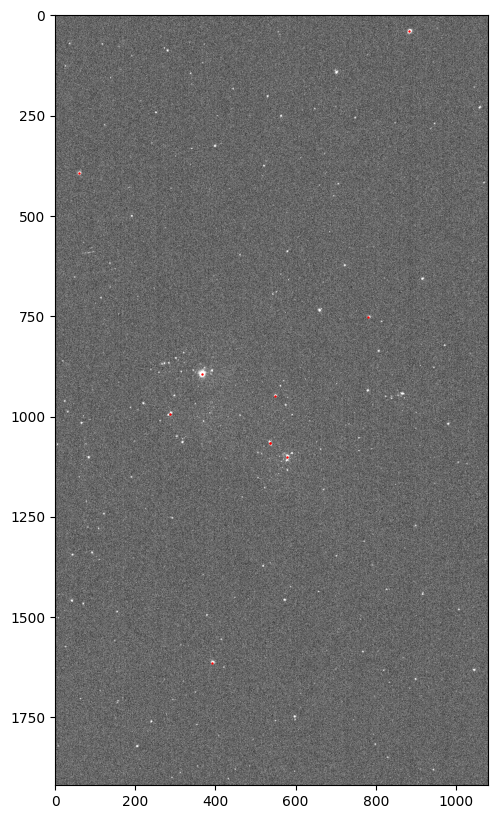

In [18]:
plt.figure(figsize=(10, 10))

vmin, vmax = np.percentile(data, [0.1, 99.9])
plt.imshow(data, vmin=vmin, vmax=vmax, cmap="gray")

plt.scatter(stars['xcentroid'][0:10], stars['ycentroid'][0:10], s=0.5, c="red")

#plt.scatter([366.1211], [894.060312], c='blue')

In [19]:
selected_stars = stars[0:10]

In [20]:
selected_ras = stars['ra'][0:10]
selected_decs = stars['dec'][0:10]

In [21]:
AP_RADIUS = 5.0
ANN_IN = 8.0
ANN_OUT = 14.0

def aperture_flux_and_bkg(frame, positions_xy):
    aper = CircularAperture(positions_xy, r=AP_RADIUS)
    ann  = CircularAnnulus(positions_xy, r_in=ANN_IN, r_out=ANN_OUT)

    phot_aper = aperture_photometry(frame, aper)
    phot_ann  = aperture_photometry(frame, ann)

    aper_sum = np.array(phot_aper["aperture_sum"], dtype=np.float64)
    ann_sum  = np.array(phot_ann["aperture_sum"], dtype=np.float64)

    bkg_per_pix = ann_sum / ann.area
    bkg_in_aper = bkg_per_pix * aper.area
    return aper_sum - bkg_in_aper, bkg_per_pix

In [22]:
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np

def remove_stars_near_target(stars, wcs, target_ra, target_dec, radius_arcsec=5.0,
                             x_col="x", y_col="y"):
    """
    Remove detected stars within radius_arcsec of (target_ra, target_dec).
    stars: Astropy Table or similar supporting column access + boolean masking.
    wcs: astropy.wcs.WCS
    """
    if stars is None or len(stars) == 0:
        return stars

    # pixel -> world for detections
    xs = np.asarray(stars[x_col], dtype=float)
    ys = np.asarray(stars[y_col], dtype=float)
    ras, decs = wcs.all_pix2world(xs, ys, 0)

    det = SkyCoord(ras*u.deg, decs*u.deg)
    tgt = SkyCoord(target_ra*u.deg, target_dec*u.deg)

    sep = det.separation(tgt).arcsec
    keep = sep > float(radius_arcsec)

    return stars[keep]

In [23]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from tqdm import tqdm
import warnings
from astropy.wcs import FITSFixedWarning

warnings.simplefilter("ignore", FITSFixedWarning)

N_COMP = 9
EPS = 1e-12

def safe_net(flux, bkg):
    net = flux - bkg
    net = np.where(net > 0, net, np.nan)
    return net

rows = []

for file in tqdm(files):
    try:
        hdu = fits.open(file)[0]
        data = hdu.data
        hdr  = hdu.header

        stars = get_stars_positions(data)  # must contain pixel positions
        stars.sort('flux', reverse=True)

        # --- Remove any detected star within 5" of target (if header WCS works) ---
        try:
            wcs0 = WCS(hdr)
            # This will fail if header has no usable WCS; we just skip filtering then
            _ = wcs0.wcs.crval  # simple touch
            stars = remove_stars_near_target(
                stars, wcs0, TARGET_RA, TARGET_DEC,
                radius_arcsec=5.0, x_col="x", y_col="y"
            )
            stars.sort('flux', reverse=True)
        except Exception:
            pass

        # Solve astrometry with filtered detections
        wcs_header, wcs = solve_astrometry_local(stars[0:60], hdr['RA'], hdr['DEC'])
        update_header(hdu, wcs_header)

        # (Optional but recommended) Now that you have a good WCS, filter again robustly
        # in case the header WCS was poor/wrong.
        stars = remove_stars_near_target(
            stars, wcs, TARGET_RA, TARGET_DEC,
            radius_arcsec=5.0, x_col="xcentroid", y_col="ycentroid"
        )
        stars.sort('flux', reverse=True)

        # Build positions: target first, then selected comps (these are your fixed sky comps)
        tx, ty = wcs.world_to_pixel_values(TARGET_RA, TARGET_DEC)
        xs, ys = wcs.world_to_pixel_values(selected_ras, selected_decs)

        pos = [(float(tx), float(ty))] + [(float(x), float(y)) for x, y in zip(xs, ys)]
        if len(pos) < 1 + N_COMP:
            continue

        flux, bkgs = aperture_flux_and_bkg(data, pos)
        flux = np.asarray(flux, dtype=float)
        bkgs = np.asarray(bkgs, dtype=float)

        net = safe_net(flux, bkgs)
        target_net = net[0]
        comp_net   = net[1:1+N_COMP]

        if not np.isfinite(target_net):
            continue

        ratios = target_net / (comp_net + EPS)
        comp_med = np.nanmedian(comp_net)
        rel_flux = target_net / (comp_med + EPS)

        row = {
            "frame": file,
            "date_obs": hdr.get("DATE-OBS", None),

            "target_flux": flux[0],
            "target_bkg":  bkgs[0],
            "target_net":  target_net,

            "comp_net_median": comp_med,
            "rel_flux_target_over_comp_median": rel_flux,

            "ratio_mean": np.nanmean(ratios),
            "ratio_median": np.nanmedian(ratios),
            "n_valid_comp": int(np.sum(np.isfinite(comp_net))),
        }

        for i in range(1, N_COMP + 1):
            row[f"star_{i}_flux"]  = flux[i]
            row[f"star_{i}_bkg"]   = bkgs[i]
            row[f"star_{i}_net"]   = comp_net[i-1]
            row[f"star_{i}_ratio"] = ratios[i-1]

        rows.append(row)

    except Exception as e:
        print(f"Skipping file {file} due to error: {e}")

df_out = pd.DataFrame(rows).sort_values("date_obs").reset_index(drop=True)

 20%|██        | 19/93 [00:13<00:46,  1.58it/s]

Skipping file Ago08/2025-08-08_18-38-24__0.30s_0018.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 22%|██▏       | 20/93 [00:13<00:37,  1.93it/s]

Skipping file Ago08/2025-08-08_18-38-29__0.30s_0019.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 23%|██▎       | 21/93 [00:13<00:31,  2.28it/s]

Skipping file Ago08/2025-08-08_18-38-32__0.30s_0020.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 24%|██▎       | 22/93 [00:13<00:28,  2.53it/s]

Skipping file Ago08/2025-08-08_18-38-36__0.30s_0021.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 25%|██▍       | 23/93 [00:14<00:25,  2.74it/s]

Skipping file Ago08/2025-08-08_18-38-40__0.30s_0022.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 26%|██▌       | 24/93 [00:14<00:23,  2.97it/s]

Skipping file Ago08/2025-08-08_18-38-44__0.30s_0023.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 27%|██▋       | 25/93 [00:14<00:21,  3.21it/s]

Skipping file Ago08/2025-08-08_18-38-49__0.30s_0024.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 28%|██▊       | 26/93 [00:14<00:21,  3.06it/s]

Skipping file Ago08/2025-08-08_18-39-01__0.30s_0025.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 29%|██▉       | 27/93 [00:15<00:20,  3.24it/s]

Skipping file Ago08/2025-08-08_18-39-04__0.30s_0026.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 31%|███       | 29/93 [00:15<00:16,  3.99it/s]

Skipping file Ago08/2025-08-08_18-39-08__0.30s_0027.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.
Skipping file Ago08/2025-08-08_18-39-12__0.30s_0028.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 33%|███▎      | 31/93 [00:15<00:12,  5.08it/s]

Skipping file Ago08/2025-08-08_18-39-16__0.30s_0029.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.
Skipping file Ago08/2025-08-08_18-39-20__0.30s_0030.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 35%|███▌      | 33/93 [00:16<00:10,  5.67it/s]

Skipping file Ago08/2025-08-08_18-39-24__0.30s_0031.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.
Skipping file Ago08/2025-08-08_18-39-28__0.30s_0032.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 38%|███▊      | 35/93 [00:16<00:09,  6.24it/s]

Skipping file Ago08/2025-08-08_18-39-33__0.30s_0033.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.
Skipping file Ago08/2025-08-08_18-39-36__0.30s_0034.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 39%|███▊      | 36/93 [00:16<00:12,  4.72it/s]

Skipping file Ago08/2025-08-08_18-39-40__0.30s_0035.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 40%|███▉      | 37/93 [00:17<00:14,  3.94it/s]

Skipping file Ago08/2025-08-08_18-39-44__0.30s_0036.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


 42%|████▏     | 39/93 [00:18<00:22,  2.38it/s]

Skipping file Ago08/2025-08-08_18-39-53__0.30s_0038.fits due to error: Astrometry failed: no match. Not enough stars or wrong index/scale hints.


100%|██████████| 93/93 [02:03<00:00,  1.33s/it]


In [28]:
df_out["rel_flux_norm1"] = (
    df_out["rel_flux_target_over_comp_median"] /
    df_out["rel_flux_target_over_comp_median"].median()
)

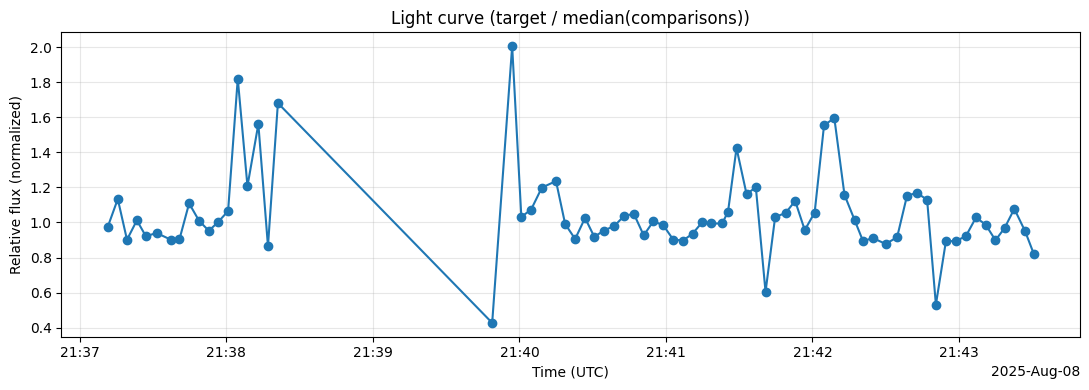

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Parse time and clean
dfp = df_out.copy()
dfp["date_obs"] = pd.to_datetime(dfp["date_obs"], errors="coerce", utc=True)
dfp = dfp.dropna(subset=["date_obs", "rel_flux_target_over_comp_median"]).sort_values("date_obs")

# 2) Normalize to 1 (optional but usually best for visualization)
y = dfp["rel_flux_target_over_comp_median"].to_numpy(dtype=float)
y = y / np.nanmedian(y)

# (Optional) remove crazy outliers for a cleaner plot
# keep = (y > 0.5) & (y < 1.5)
# dfp, y = dfp[keep], y[keep]

# 3) Plot
fig, ax = plt.subplots(figsize=(11, 4))
ax.plot(dfp["date_obs"], y, marker="o", linestyle="-")
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Relative flux (normalized)")
ax.set_title("Light curve (target / median(comparisons))")

# nicer date axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

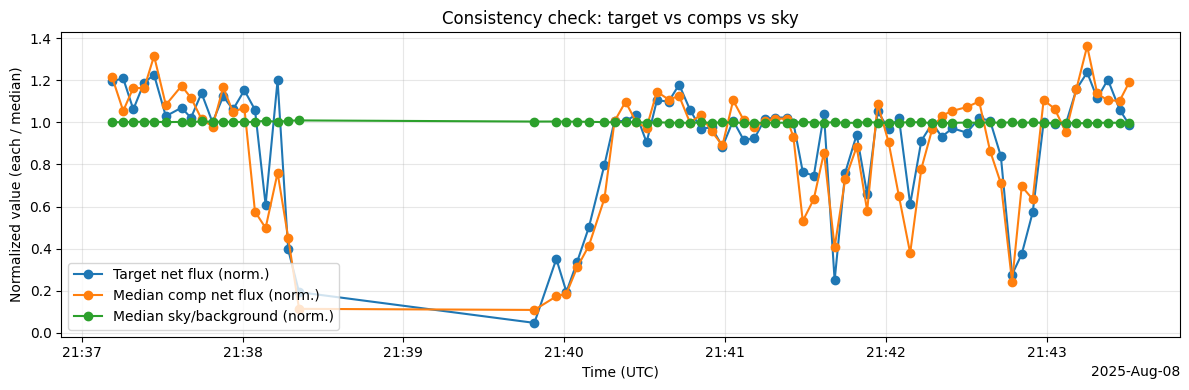

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

N_COMP = 9

dfp = df_out.copy()
dfp["date_obs"] = pd.to_datetime(dfp["date_obs"], errors="coerce", utc=True)
dfp = dfp.sort_values("date_obs")

# --- Build series ---
# 1) Target net flux
t_net = dfp["target_net"].astype(float)

# 2) Comparison ensemble net flux (median of comp net fluxes)
comp_net_cols = [f"star_{i}_net" for i in range(1, N_COMP + 1) if f"star_{i}_net" in dfp.columns]
comp_med_net = dfp[comp_net_cols].median(axis=1, skipna=True).astype(float)

# 3) Sky/background level (median of all star bkgs)
bkg_cols = [f"star_{i}_bkg" for i in range(1, N_COMP + 1) if f"star_{i}_bkg" in dfp.columns]
sky_med_bkg = dfp[bkg_cols].median(axis=1, skipna=True).astype(float)

# Optional: include target background too
# sky_med_bkg = dfp[["target_bkg"] + bkg_cols].median(axis=1, skipna=True).astype(float)

# --- Keep only good rows ---
mask = (
    dfp["date_obs"].notna() &
    np.isfinite(t_net) &
    np.isfinite(comp_med_net) &
    np.isfinite(sky_med_bkg)
)
dfp = dfp.loc[mask].copy()
t_net = t_net.loc[mask]
comp_med_net = comp_med_net.loc[mask]
sky_med_bkg = sky_med_bkg.loc[mask]

# --- Normalize each series to its own median (so they overlay nicely) ---
def norm_med(x):
    x = x.to_numpy(dtype=float)
    return x / (np.nanmedian(x) + 1e-12)

t_n   = norm_med(t_net)
c_n   = norm_med(comp_med_net)
sky_n = norm_med(sky_med_bkg)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dfp["date_obs"], t_n, marker="o", linestyle="-", label="Target net flux (norm.)")
ax.plot(dfp["date_obs"], c_n, marker="o", linestyle="-", label="Median comp net flux (norm.)")
ax.plot(dfp["date_obs"], sky_n, marker="o", linestyle="-", label="Median sky/background (norm.)")

ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Normalized value (each / median)")
ax.set_title("Consistency check: target vs comps vs sky")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# df_out / CSV OUTPUT DESCRIPTION
# =============================================================================
#
# Each row corresponds to ONE processed frame (one FITS image).
#
# Columns:
#
# frame
#     Path or filename of the processed FITS frame.
#
# date_obs
#     Observation timestamp read from FITS header (DATE-OBS).
#     ISO format string. Used for chronological ordering.
#
# target_flux
#     Raw aperture flux measured at the target position.
#     Includes sky/background contribution.
#
# target_bkg
#     Estimated background level measured for the target aperture.
#
# target_net
#     Background-subtracted target flux:
#         target_flux - target_bkg
#     Non-positive values are set to NaN.
#
# comp_net_median
#     Median background-subtracted flux of all comparison stars
#     used in this frame. This represents the reference ensemble
#     brightness level.
#
# rel_flux_target_over_comp_median
#     Differential photometry measurement:
#         target_net / median(comparison_star_net_flux)
#     This is the main normalized light curve quantity.
#
# ratio_mean
#     Mean of individual ratios:
#         target_net / star_i_net
#     Computed across all comparison stars. Diagnostic only.
#
# ratio_median
#     Median of individual ratios:
#         target_net / star_i_net
#     More robust diagnostic against outliers.
#
# n_valid_comp
#     Number of comparison stars with valid (finite) net flux
#     used in this frame.
#
# star_i_flux   (i = 1..N_COMP)
#     Raw aperture flux measured for comparison star i.
#
# star_i_bkg
#     Estimated background level for comparison star i.
#
# star_i_net
#     Background-subtracted flux for comparison star i:
#         star_i_flux - star_i_bkg
#
# star_i_ratio
#     Ratio between target and comparison star i:
#         target_net / star_i_net
#     Used for diagnostics and stability checks.
#
# flag_target_similar_to_star1
#     Boolean diagnostic flag indicating whether the target net
#     flux is within ±2% of the brightest comparison star.
#     Used only as a sanity check.
#
# Notes:
# - One row = one exposure/frame.
# - Time evolution (light curve) should be computed using
#   rel_flux_target_over_comp_median.
# - Absolute flux values are not calibrated magnitudes.
# =============================================================================

df_out.to_csv("Ago08.csv", index=False)